In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from rasterio.mask import mask
from datetime import datetime
import os

In [2]:
boundary_path = "../geojson/Cbe2011Wards.geojson"
raster_path = "../tif/20240207T051001_20240207T052026_T43PGN.tif"

In [3]:
# Extract the file name
file_name = os.path.basename(raster_path)

# Extract the date string (first 8 characters after 'T' in the file name)
date_str = file_name.split("T")[0]  # "20240207"

# Convert the string to a datetime object for formatting
date_obj = datetime.strptime(date_str, "%Y%m%d")

# Format the date (e.g., "February 7, 2024")
formatted_date = date_obj.strftime("%b, %Y")

print("Extracted Date:", formatted_date)

Extracted Date: Feb, 2024


In [4]:
# Update no data values
# with rasterio.open(raster_path, "r+") as dataset:
#     dataset.nodata = -99

In [5]:
# Read the boundary file
boundary = gpd.read_file(boundary_path)
boundary = boundary.dissolve()


In [6]:
# Open the raster file
# raster = rasterio.open(raster_path)
# Read the raster
nodata_value = -99
with rasterio.open(raster_path) as src:
    transform = src.transform
    raster_crs = src.crs
    

if raster_crs != boundary.crs:
    boundary = boundary.to_crs(raster_crs)


# Use the boundary to mask and clip the raster
# Extract the boundary geometry
boundary_geom = boundary.geometry.values
with rasterio.open(raster_path) as src:
    # Apply the mask to clip the raster by the boundary
    clipped_data, clipped_transform = mask(src, boundary_geom, crop=True, nodata=-99)
    
masked_data = np.ma.masked_where(clipped_data != 0, clipped_data)

In [7]:
masked_data = masked_data[0]

In [8]:
# # Calculate extent of the raster (to plot correctly)
# # The extent is derived from the affine transform and the shape of the raster
# rows, cols = masked_data.shape
# extent = [transform[2], transform[2] + transform[0] * cols, transform[5] + transform[4] * rows, transform[5]]
# # Plot the masked raster data (built-up areas)
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(masked_data, cmap='coolwarm', extent=extent)
# boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)  # Plot the boundary on top
# ax.set_title("Built-Up Areas")
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# plt.show()

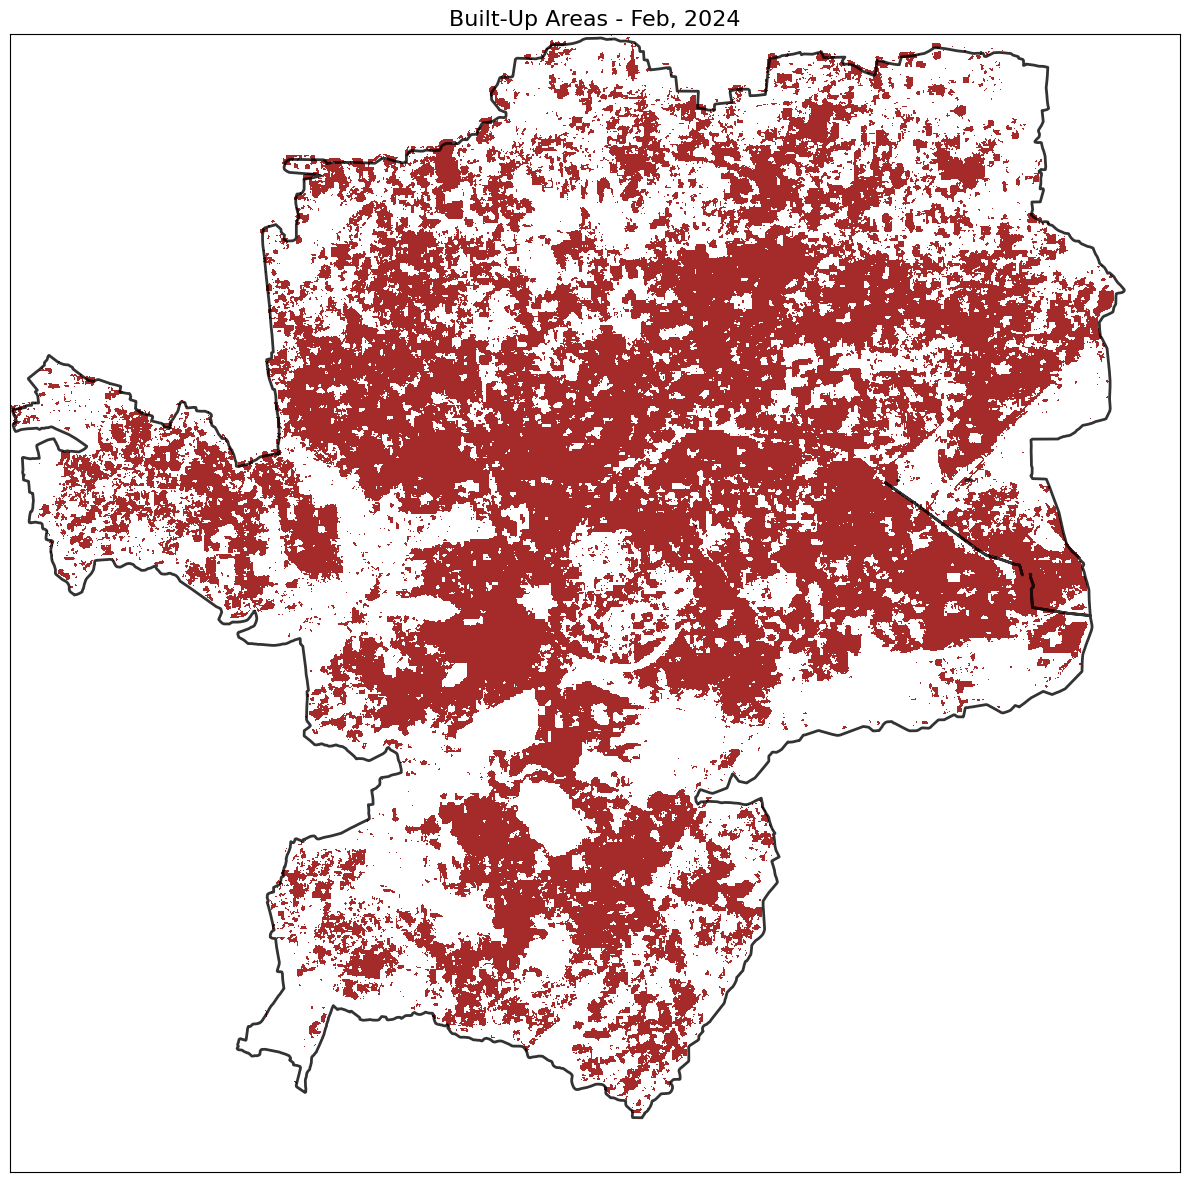

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a custom colormap (optional, highlights built-up areas better)
built_up_cmap = ListedColormap(['brown', 'brown'])  # Non-built-up as light gray, built-up as brown

# Calculate the extent of the raster
rows, cols = masked_data.shape
extent = [
    transform[2],  # Min Longitude
    transform[2] + transform[0] * cols,  # Max Longitude
    transform[5] + transform[4] * rows,  # Min Latitude
    transform[5],  # Max Latitude
]

# Plot the masked raster data (built-up areas)
fig, ax = plt.subplots(figsize=(12, 12))

# Show raster data with improved colormap and extent
ax.imshow(masked_data, cmap=built_up_cmap, extent=extent, interpolation="nearest")

# Overlay the boundary with transparency and improved styling
boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, alpha=0.8)

# Add title and labels
ax.set_title(f"Built-Up Areas - {formatted_date}", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

# Add gridlines for better spatial reference
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)


# Set aspect ratio for better geographic visualization
# ax.set_aspect('equal', 'box')

# Show the plot
plt.tight_layout()
plt.show()
